<a href="https://colab.research.google.com/github/AbdallahOmarAhmed/Brain-Tumor-Detection/blob/main/tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor Detection using UNet**

In [ ]:
# setup kaggle
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
# download data set
! kaggle datasets download -d tinashri/brain-tumor-segmentation-datasets
! unzip -q brain-tumor-segmentation-datasets.zip
# ! kaggle datasets download -d muhammadusmansaeed/brain-tumor-segmentation
# ! unzip -q brain-tumor-segmentation.zip

In [1]:
# imports
import torch
import shutil
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os



In [2]:
# configs 
batch_size = 40
img_size = 256
learning_rate = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100

In [3]:
# data loader
class MyDataSet(Dataset):
    def __init__(self, img_size=img_size, dir_path='data/', test=False):
        self.resize =  transforms.Resize(img_size)
        self.images_path = os.path.join(dir_path, "images")
        self.masks_path = os.path.join(dir_path, "masks")
        self.images = os.listdir(self.images_path)
        self.masks = os.listdir(self.masks_path)
        self.test = test
        
    def __len__(self):
        return 500 if self.test else len(self.images)-500

    def __getitem__(self, index): 
        if not self.test:
          index += 500 
        self.image = self.resize(read_image(os.path.join(self.images_path, self.images[index])))/255
        self.mask = self.resize(read_image(os.path.join(self.masks_path, self.masks[index])))/255
        return self.image, self.mask

In [4]:
# make model
class block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding='same')
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.LeakyReLU(inplace=True)
        self.sig = nn.Sigmoid()
        self.start_conv = nn.Conv2d(1, 32, 9, padding='same')

        self.down_block1 = block(32, 64)
        self.down_block2 = block(64, 128)
        self.down_block3 = block(128, 256)
        self.down_block4 = block(256, 512)

        self.up_block1 = block(512, 512*4)
        self.up_block2 = block(512, 256*4)
        self.up_block3 = block(256, 128*4)
        self.up_block4 = block(128, 64*4)

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.PixelShuffle(2)

        self.conv1 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.end_conv = nn.Conv2d(64, 1, 1)


    def forward(self, x):
        x = self.start_conv(x)
        res1 = self.down_block1(x)
        x = self.pool(res1)
        res2 = self.down_block2(x)
        x = self.pool(res2)
        res3 = self.down_block3(x)
        x = self.pool(res3)
        res4 = self.down_block4(x)
        x = self.pool(res4)

        x = self.up(self.up_block1(x)) + res4
        x = self.up(self.up_block2(x)) + res3
        x = self.up(self.up_block3(x)) + res2
        x = self.up(self.up_block4(x)) + res1

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sig(self.end_conv(x))

        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
# initialize components 
data = MyDataSet()
test = MyDataSet(test=True)
print(len(data), 'image')
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test, batch_size=10, shuffle=True, num_workers=2)
model = UNet()
model.to(device)
model.train()
model.load_state_dict(torch.load("/content/drive/MyDrive/UNet/modelUNet60_epoch.pth"))
print(model.count_parameters(),'parameters')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
myloss = nn.BCELoss()

In [ ]:
# training
min_loss = 1
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    test_loss = 0
    c = 0
    for x,y in tqdm(dataloader):
        c += 1
        images = x.to(device)
        labels = y.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = myloss(output, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    epoch_loss /= c
    model.eval()
    c = 0
    with torch.no_grad():
        for x0,y0 in testloader:
            c += 1
            images = x0.to(device)
            labels = y0.to(device)
            output = model(images)
            loss = myloss(output, labels)
            test_loss += loss
        test_loss /= c
        if test_loss < min_loss:
          min_loss = test_loss
          torch.save(model.state_dict(), '/content/drive/MyDrive/UNet/model.pth')
          # shutil.copy("/content/modelUNet100_epoch.pth", "/content/drive/MyDrive/UNet/")
        train_losses.append(epoch_loss.item())
        test_losses.append(test_loss.item())
        print(epoch + 1, '/', num_epochs, 'loss = ', epoch_loss.item(), 'test_loss = ', test_loss.item())


In [ ]:
plt.plot(train_losses, label = "train")
plt.plot(test_losses, label = "test")
plt.show()

In [6]:
# initialize for test
data = MyDataSet(test=True)
dataloader = DataLoader(data, batch_size=1, shuffle=True, num_workers=2)
model = UNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/UNet/modelUNet60_epoch.pth", map_location=torch.device('cpu')))
model.eval()
myloss = nn.BCELoss()
to_pil = transforms.ToPILImage()

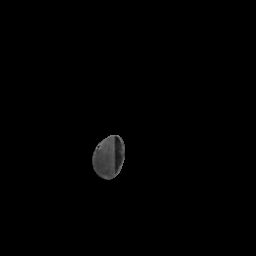

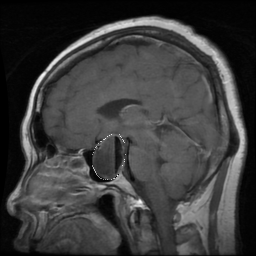

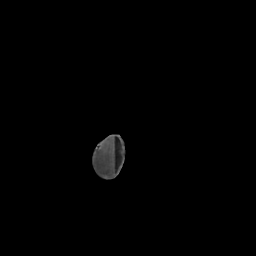

In [14]:
# test
for x,y in dataloader:
  images = x.squeeze(0)
  labels = y.squeeze(0)
  out = model(images) >= 0.5
  # print(myloss(out, labels))
  display(to_pil(out*images))
  display(to_pil(images+labels*10))
  display(to_pil(labels*images))
  break